# BACKPROJECT IMAGE CLASSIFICATION RESULTS ONTO THE POINT CLOUD

In [ ]:
#second layer
from geomapi.nodes import *

#first layer
import geomapi.utils as ut
import geomapi.utils.geometryutils as gmu
import geomapi.utils.imageutils as imu

#third layer
import geomapi.tools as tl



In [ ]:
imgNodes=tl.img_xml_to_nodes(xmlPath,skip=10,filterByFolder=True) 

In [1]:
from rdflib import Graph, URIRef
import os.path
import importlib
import numpy as np
import xml.etree.ElementTree as ET
import open3d as o3d
import uuid    
import pye57 
import ifcopenshell
import ifcopenshell.geom as geom
import ifcopenshell.util
import ifcopenshell.util.selector
import random as rd
import pandas as pd
import cv2
import laspy
import copy
from matplotlib import pyplot as plt
import math
import pathlib
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from tensorflow import keras

#IMPORT MODULES
from context import geomapi  -> this is if you have geomapi

from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
from geomapi.tools import progresstools as pt
from geomapi.utils import imageutils as iu
import geomapi.tools as tl

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

## USER INPUT

general

In [4]:
projectPath= os.path.join("D:\\Data\\2023-01 Colosseum")
sessionPath = os.path.join(projectPath,"Research")

gallery 1

In [5]:
#PCD
lasPath=os.path.join(projectPath,"PCD","COLOSSEO_UNITO_test4 - Cloud - classes.las")
outputlasPath=os.path.join(projectPath,"PCD","COLOSSEO_UNITO_test4 - Cloud - classes - out.las")

#Images
# imgGraphPath=os.path.join(sessionPath,"IMG","imgGraph.ttl")
# materialClassificationGraphPath=os.path.join(sessionPath,"IMG_training_224","materialClassificationGraph.ttl")
# colors=[(255,0,0),(0,255,0),(0,0,255)]
xmlPath=os.path.join(projectPath,'Research','IMG','cameras.xml')
pixelWidth=0.0060975609756097563
focalLength35mm= 2668.8837741268403

#offsets
transform=np.array([[1.0,0.0, 0.0, -2.3119001244394034e+06 ], 
                [0.0, 1.0, 0.0, -4.6406591797101609e+06],
                [0.0, 0.0, 1.0 ,-2.5068223291342328e+01],
                [0.0 ,0.0, 0.0, 1.000000000000]])

#classification
modelPath=os.path.join(sessionPath,"IMG_training_224","Model_MobileNetV2__materials")
tempfolder=pathlib.Path(os.path.join(sessionPath,'IMG_training_224','temp'))
batch_size = 32 #! same as model
# class_names_m=[0.0,1.0]
# class_names_tc=[0.0,1.0,2.0]
# class_names_d=[1.0,2.0]

colors=[(255,0,0),(0,255,0),(0,0,255)]
pixelRange=224
rayOffsetDistance=0.2

facade

In [257]:
#PCD
lasPath=os.path.join(projectPath,"PCD","COLOSSEO_UNITO_test5 - Cloud - classes.las")
outputlasPath=os.path.join(projectPath,"PCD","COLOSSEO_UNITO_test5 - Cloud - classes - out.las")
transform=np.array([[1.0,0.0, 0.0, -2.3119001244394034e+06 ], 
                [0.0, 1.0, 0.0, -4.6406591797101609e+06],
                [0.0, 0.0, 1.0 ,-2.5068223291342328e+01],
                [0.0 ,0.0, 0.0, 1.000000000000]])
#Images
xmlPath=os.path.join(projectPath,'IMG3','Cantiere_pilota_cameras.xml')
sensorid=11
pixelWidth=0.0043948613649283609
focalLength35mm= 8196.120157529791

rotation=np.array([[4.1458532257958308e-01, 9.0392097872801924e-01 ,-1.0509935545455225e-01,0],
                        [ 9.0916313459383069e-01, -4.1641033853698489e-01, 4.9824346492534097e-03,0],
                        [-3.9260730980247453e-02, -9.7618103725144317e-02, -9.9444924497331855e-01,0],
                        [0,0,0,1]])

#classification
modelMPath=os.path.join(sessionPath,"Facade_classification","Model_MobileNetV2__materials")
modelTCPath=os.path.join(sessionPath,"Facade_classification","Model_MobileNetV2_BuildingTechniques")
modelDPath=os.path.join(sessionPath,"Facade_classification","Model_MobileNetV2_Damages")

tempfolder=pathlib.Path(os.path.join(sessionPath,'Facade_classification','temp'))
batch_size = 32 #! same as model
class_names_m=[0.0,1.0]
class_names_tc=[0.0,1.0,2.0]
class_names_d=[1.0,2.0]

filteringWeight=3
colors=[(255,0,0),(0,255,0),(0,0,255)]
pixelRange=224
rayOffsetDistance=0.2
skip=10 #nth file tu use

## PREPROCESS POINT CLOUD

Create point cloud node with proper offset.

In [275]:
las  = laspy.read(lasPath)
pcdNode=PointCloudNode(name=ut.get_filename(lasPath),
                        lasPath=lasPath,
                        resource=gmu.las_to_pcd(las,transform=transform)
                        )

## PREPROCESS THE IMAGES WITH THE POINT CLOUD

Create imageNodes with proper offset.

In [258]:
#get list of files
files=ut.get_list_of_files(ut.get_folder(xmlPath))
files=[f for f in files if f.endswith('.JPG')]

#select every fifth files
imgNodes=[]
for f in files[0::skip]:    
    imgNodes.append(ImageNode(name=ut.get_filename(f),
              path=f,
              xmlPath=xmlPath,
                focalLength35mm=focalLength35mm))
# apply transform to put imagery in local coordinates
for n in imgNodes:
    n.cartesianTransform=rotation @ n.cartesianTransform    
meshes=[gmu.generate_visual_cone_from_image(n.cartesianTransform, height =0.4) for n in imgNodes]
print(str(len(imgNodes))+ " Nodes created!")

89 Nodes created!


In [9]:
{key:value for key, value in imgNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': 'D:\\Data\\2023-01 Colosseum\\IMG3\\Cantiere_pilota_cameras.xml',
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 8192,
 'imageHeight': 5460,
 'focalLength35mm': 8196.120157529791,
 '_subject': rdflib.term.URIRef('file:///DJI_20220519073712_0001'),
 '_graph': None,
 '_graphPath': None,
 '_path': 'D:/Data/2023-01 Colosseum/IMG3/DJI_20220519073712_0001.JPG',
 '_name': 'DJI_20220519073712_0001',
 '_timestamp': '2022-05-19T07:37:12',
 '_resource': None,
 '_cartesianTransform': array([[-7.27283391e-01, -1.67728008e-01,  6.65526998e-01,
         -3.14148088e+01],
        [-6.86335576e-01,  1.79898290e-01, -7.04684385e-01,
          3.26182963e+01],
        [-1.53186098e-03, -9.69280104e-01, -2.45954737e-01,
          4.89940760e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 'resolutionUnit': 2,
 'geospatialTransform': [41.890681888888885, 12.491183527777777, 122.366],
 'coordinateSystem': 'geospatial-wgs84'}

In [10]:
# imgNodes=tl.img_xml_to_nodes(xmlPath)
# imgNodes=[n for n in imgNodes if n.cartesianTransform is not None and n.path is not None and os.path.exists(n.path) and n.resource is not None]
# for n in imgNodes:
#     n.cartesianTransform=rotation @ n.cartesianTransform
#     #n.offsetTransform=transform
#     n.focalLength35mm=f
#     n.pixelWidth=pixelWidth

# #filter duplicates (some metaShape files have same imgNodes multiple times)
# imgNodes2=[]
# nameList=[]
# for elem in imgNodes:
#     if elem.subject not in nameList:
#         imgNodes2.append(elem)
#         nameList.append(elem.subject)
# imgNodes=imgNodes2
# meshes=[gmu.generate_visual_cone_from_image(n.cartesianTransform, height =0.4) for n in imgNodes]

# print(str(len(imgNodes))+ " Nodes created!")

visualize the inputs

In [11]:
# joinedImages=gmu.join_geometries(meshes)
# joinedImages=joinedImages.paint_uniform_color([1,0,0])
# o3d.visualization.draw_geometries([joinedImages]+[pcdNode.resource])

Get depth map per image.

In [259]:
import geomapi.tools.progresstools as pt

pcd=copy.deepcopy(pcdNode.resource)
for n in imgNodes:
    # ! try the pipeline first for 10 images
    # # ! the pcd is to sparce. from 10m+ the rays dont find the points anymore. can we do this for a voxelgrid?
    colorImage,depthImage=pt.project_pcd_to_rgbd_images(pcd,
                                                        n, -> imgNode because of focalLength35mm and stuff
                                                        depth_max=20)
    n.colorImage=colorImage[0]
    n.depthImage=depthImage[0]
del pcd

Visualize some depth maps  

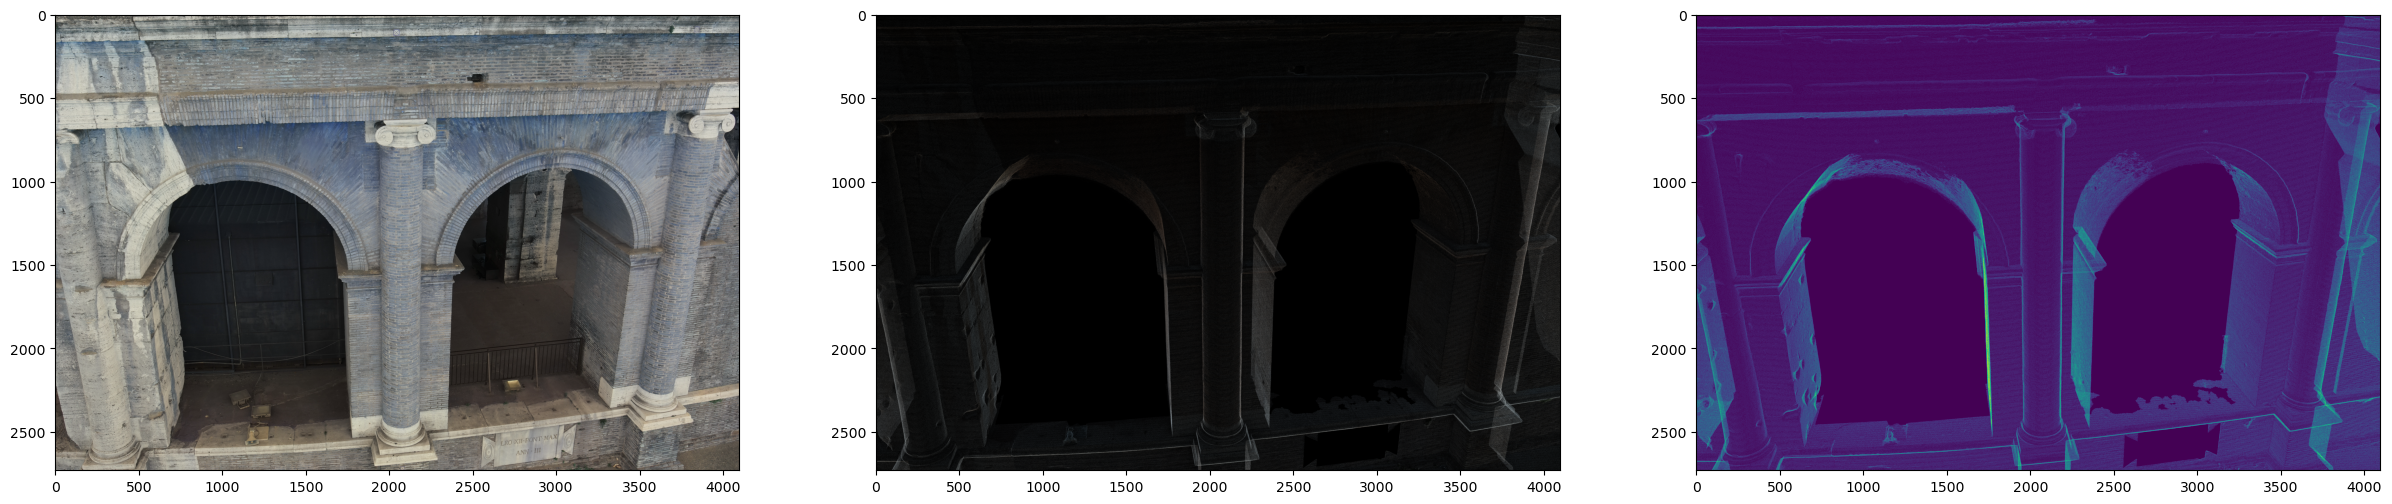

In [190]:
from matplotlib import pyplot as plt
import math
n=imgNodes[1]
fig, axs = plt.subplots(1, 3,figsize=(30, 30))
fig.set_facecolor("white")
axs[0].imshow(iu.image_resize(n.resource,1/16))
axs[1].imshow(iu.image_resize(n.colorImage,1/16))
axs[2].imshow(iu.image_resize(n.depthImage,1/16))
plt.show()

subdivide images and raytrace the point cloud.

In [260]:
imgTrainingNodes=[]
for n in imgNodes:
    #subdivide images.
    imgList,roiList=iu.subdivide_image(n.resource,width=pixelRange,height=pixelRange,includeLast=False)    
    
    #store centers of subdivision as 3D coordinates.
    minl,meanl,maxl=ut.get_min_average_and_max_value([n.depthImage[roi[0]:roi[1],roi[2]:roi[3]] for roi in roiList],threshold=0.80)    
    
    #! insert Nan for those windows that have to much of a depth difference
    # np.where()
       
    imagePoints=np.vstack([np.array([sum(x[:2])/2,sum(x[2:4])/2]) for x in roiList])
    rays=n.create_rays(imagePoints,minl+rayOffsetDistance) #
    #! not needed to compute pcd here +slow
    _,endpoints=gmu.rays_to_points(rays)
    
    nodeList=[]
    for img,roi,ray,endpoint in zip(imgList,roiList,rays,endpoints):
        nodeList.append(ImageNode(resource=img,
                                isDerivedFrom=n.subject,
                                roi=roi,
                                ray=ray,
                                point=endpoint))                    
    #add to nodelist   
    imgTrainingNodes.extend(nodeList) 
print(len(imgTrainingNodes))

76896


In [169]:
for n in imgNodes:
    # del n.resource
    del n.colorImage
    del n.depthImage

visualize the initial point cloud and the raytraced rays

In [15]:
# array=np.vstack([n.ray for n in imgTrainingNodes if not any(np.isnan([p for p in n.point]))])
# rays = o3d.core.Tensor(array,dtype=o3d.core.Dtype.Float32)  
# line_set=gmu.rays_to_lineset(rays)
# line_set.colors=o3d.utility.Vector3dVector(np.vstack((np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,1]),np.zeros((len(line_set.lines)-3,3)))))
# o3d.visualization.draw_geometries([line_set]+[pcdNode.resource])

store subImages for classification

In [261]:
import shutil

os.mkdir(tempfolder) if not os.path.exists(tempfolder) else None                   
temp=os.path.join(tempfolder,'0.0')
shutil.rmtree(temp) if os.path.exists(temp) else None 
os.mkdir(temp) if not os.path.exists(temp) else None                   

for n in imgTrainingNodes:
    path=os.path.join(temp,n.name+'.png')
    cv2.imwrite(path, n.resource)

In [78]:
{key:value for key, value in imgTrainingNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 224,
 'imageHeight': 224,
 'focalLength35mm': None,
 '_subject': rdflib.term.URIRef('file:///27881d94-a607-11ed-8548-c8f75043ce59'),
 '_graph': None,
 '_graphPath': None,
 '_path': None,
 '_name': '27881d94-a607-11ed-8548-c8f75043ce59',
 '_timestamp': None,
 '_resource': array([[[102, 105, 103],
         [ 98, 101,  99],
         [111, 114, 112],
         ...,
         [137, 135, 127],
         [139, 137, 129],
         [137, 135, 127]],
 
        [[ 98, 101,  99],
         [102, 105, 103],
         [114, 117, 115],
         ...,
         [136, 134, 126],
         [140, 138, 130],
         [137, 135, 127]],
 
        [[111, 114, 112],
         [108, 111, 109],
         [110, 113, 111],
         ...,
         [133, 131, 123],
         [138, 136, 128],
         [135, 133, 125]],
 
        ...,
 
        [[109, 108, 110],
         [ 95,  94,  96],
         [ 85,  83,  83],
         ...,
         [ 81,  79,

## CLASSIFY IMAGES

prepare image dataset

In [262]:
dataset = tf.keras.utils.image_dataset_from_directory(
  tempfolder,
  labels='inferred',
  image_size=(pixelRange, pixelRange),
  batch_size=batch_size,
  shuffle=False)

#buffer for data performance
AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

Found 76896 files belonging to 1 classes.


load models

In [263]:
modelTC = tf.keras.models.load_model(modelTCPath)
modelD = tf.keras.models.load_model(modelDPath)

predict material labels

In [264]:
modelM = tf.keras.models.load_model(modelMPath)
probability_model = tf.keras.Sequential([modelM, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(dataset)
predicted_id = tf.math.argmax(predictions, axis=-1).numpy().astype(np.int32)
class_names_m=np.array(class_names_m)
predicted_id_m=class_names_m[predicted_id]
del modelM

2403/2403 [==============================] - 598s 248ms/step


predict building technique labels

In [265]:
probability_model = tf.keras.Sequential([modelTC, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(dataset)
predicted_id = tf.math.argmax(predictions, axis=-1).numpy().astype(np.int32)
class_names_tc=np.array(class_names_tc)
predicted_id_tc=class_names_tc[predicted_id]

2403/2403 [==============================] - 597s 248ms/step


predict Damage labels

In [266]:
probability_model = tf.keras.Sequential([modelD, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(dataset)
predicted_id = tf.math.argmax(predictions, axis=-1).numpy().astype(np.int32)
class_names_d=np.array(class_names_d)
predicted_id_d=class_names_d[predicted_id]

2403/2403 [==============================] - 402s 166ms/step


assign labels to subImages

In [267]:
for n,m,tc,d in zip(imgTrainingNodes,predicted_id_m,predicted_id_tc,predicted_id_d):
    n.resource=None #! flush memory
    # n.materialPredictionProbability=p
    n.materialPrediction=m
    n.techniquePrediction=tc
    n.damagePrediction=d

show some classification results

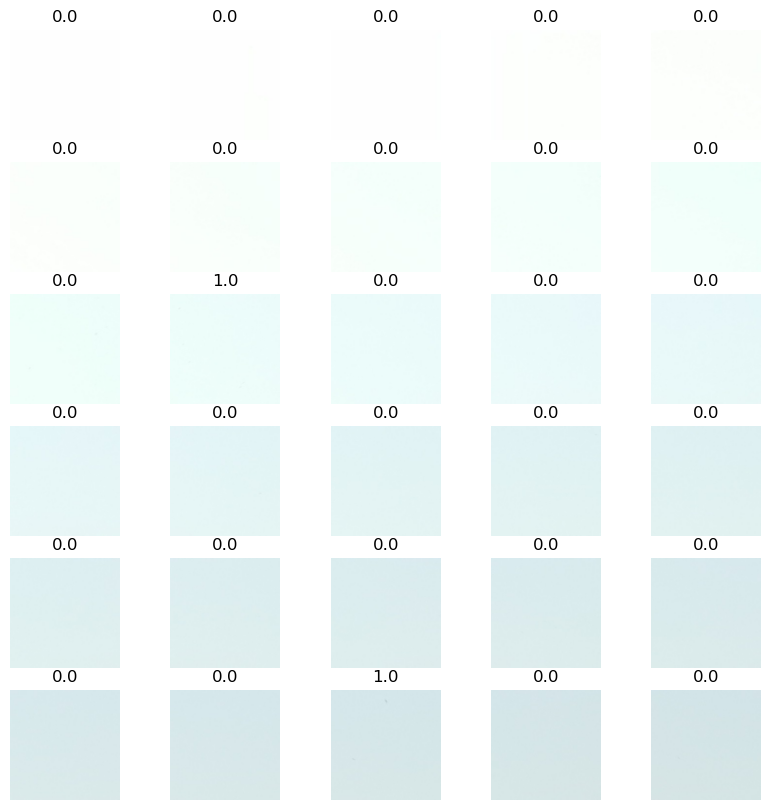

In [206]:
image_batch,_= dataset.as_numpy_iterator().next()

plt.figure(figsize=(10, 10))
for i in range(30):
  ax = plt.subplot(6, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8")) #
  plt.title(predicted_id_m[i])
  plt.axis("off")

## FORCE consistency in classification

In [268]:
for n in imgNodes:
    # select imgTrainingNodes
    indices=[i for i,tn in enumerate(imgTrainingNodes) if tn.isDerivedFrom ==n.subject]
    
    #update materialpredictions
    shape=(math.floor(n.imageHeight/pixelRange),math.floor(n.imageWidth/pixelRange))
    materialPrediction=[int(imgTrainingNodes[i].materialPrediction) for i in indices]
    materialPrediction2=pt.filter_img_classifcation_by_neighbors(materialPrediction,shape,filteringWeight)
   
    #update building technique predictions
    techniquePrediction=[int(imgTrainingNodes[i].techniquePrediction) for i in indices]
    techniquePrediction2=pt.filter_img_classifcation_by_neighbors(techniquePrediction,shape,filteringWeight)
    
    #update damage predictions
    damagePrediction=[int(imgTrainingNodes[i].damagePrediction) for i in indices]
    damagePrediction2=pt.filter_img_classifcation_by_neighbors(damagePrediction,shape,filteringWeight)

    #create secondary classification
    for i,ind in enumerate(indices):
        imgTrainingNodes[ind].materialPrediction2=materialPrediction2[i]
        imgTrainingNodes[ind].techniquePrediction2=techniquePrediction2[i]
        imgTrainingNodes[ind].damagePrediction2=damagePrediction2[i]

## SHOW RESULTS FOR FULL PICTURE

(optional) Compile result for complete images

In [252]:
import copy

images=[]
for n in imgNodes:
    image=copy.deepcopy(n.resource)
    # select nodes
    nodeList=[tn for tn in imgTrainingNodes if tn.isDerivedFrom ==n.subject]
    
    #create mask from roi
    for i,c in enumerate(class_names_d):
        roiList= [t.roi for t in nodeList if t.damagePrediction2==c and not any(np.isnan([p for p in t.point]))] 
        if len(roiList) >0:
            for roi in roiList:
                roi=image[roi[0]:roi[1],roi[2]:roi[3]] 
                roi[:,:,:]=colors[i]
    images.append(image)   

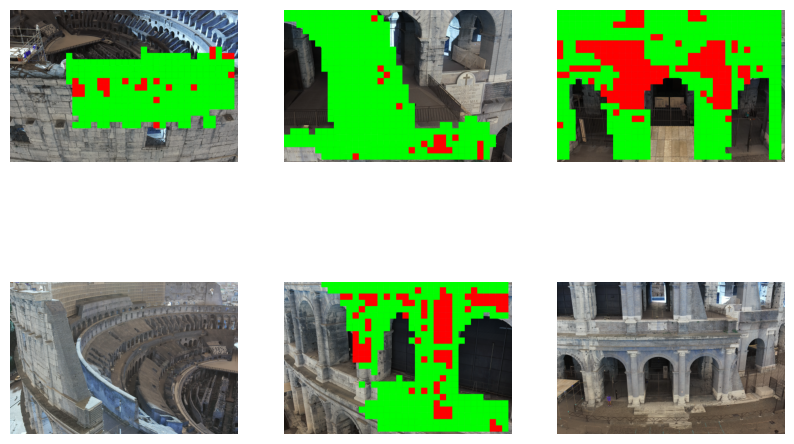

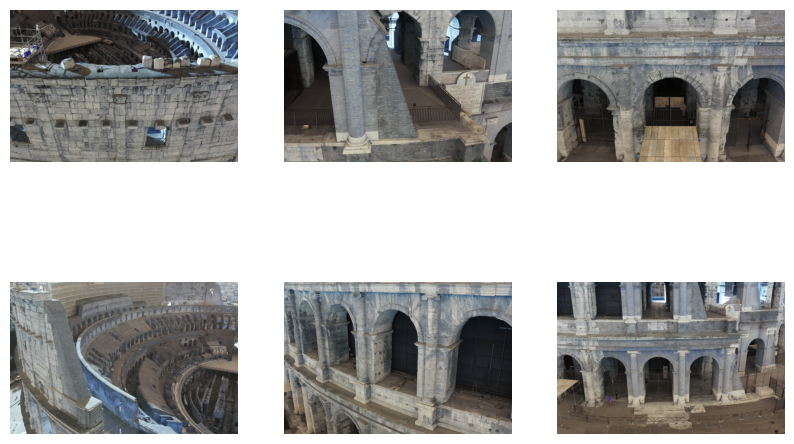

In [253]:
import math
n=[0,9]
plt.figure(figsize=(10, 10))
# for img in [n.resource for n in imgNodes]:
for i,img in enumerate(images[n[0]:n[1]]):
    ax = plt.subplot(3, 3, i+1 )
    # plt.imshow(cv2.resize(img, (math.ceil(img.shape[1]/16),math.ceil(img.shape[0]/16))))
    plt.imshow(iu.image_resize(img,scale=1/16))
    plt.axis("off")
plt.figure(figsize=(10, 10))
# for img in [n.resource for n in imgNodes]:
for i,img in enumerate([t for t in imgNodes[n[0]:n[1]]]):
    ax = plt.subplot(3, 3, i+1 )
    # plt.imshow(cv2.resize(img, (math.ceil(img.shape[1]/16),math.ceil(img.shape[0]/16))))
    plt.imshow(iu.image_resize(img.resource,scale=1/16))
    plt.axis("off")

## ASSIGN IMAGE CLASSIFICATION TO POINT CLOUD

Assign Materials

In [271]:
pointClouds=[]
for c in class_names_m:
    pcd=o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector([n.point for n in imgTrainingNodes if n.materialPrediction2 == c and not any(np.isnan([p for p in n.point]))])
    pointClouds.append(pcd)
arrM=pt.assign_point_cloud_information(pcdNode.resource,pointClouds,class_names_m)

Assign Building Techniques

In [272]:
pointClouds=[]
for c in class_names_tc:
    pcd=o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector([n.point for n in imgTrainingNodes if n.techniquePrediction2 == c and not any(np.isnan([p for p in n.point]))])
    pointClouds.append(pcd)
arrTC=pt.assign_point_cloud_information(pcdNode.resource,pointClouds,class_names_tc)

Assign Damages

In [273]:
pointClouds=[]
for c in class_names_d:
    pcd=o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector([n.point for n in imgTrainingNodes if n.damagePrediction2 == c and not any(np.isnan([p for p in n.point]))])
    pointClouds.append(pcd)
arrD=pt.assign_point_cloud_information(pcdNode.resource,pointClouds,class_names_d)
pointClouds=None

Visualize the img generated identity point clouds.

In [44]:
# o3d.visualization.draw_geometries([ref_cloud]+[line_set]+[pcdNode.resource])
# o3d.visualization.draw_geometries([ref_cloud]+[pcdNode.resource])
# o3d.visualization.draw_geometries([pcdNode.resource])

## Assign classification to the las file.

In [276]:
gmu.las_add_extra_dimensions(las,(arrM,arrTC,arrD),['imageMatClassification','imageTCClassification','imageDClassification'],['uint8','uint8','uint8'])
print(list(las.point_format.dimension_names))

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'red', 'green', 'blue', 'bimDistance', 'bimMaterial2', 'bimMaterial1', 'bimTC', '02 TC', '03 D', '01 Materiali', 'imageMatClassification', 'imageTCClassification', 'imageDClassification']


In [277]:
print(las['imageMatClassification'])
print(las['imageTCClassification'])
print(las['imageDClassification'])

[1 0 0 ... 0 0 0]
[2 0 0 ... 0 0 0]
[2 2 2 ... 1 1 1]


Export las file

In [278]:
las.write(outputlasPath)

In [ ]:
{key:value for key, value in imgNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': 'D:\\Data\\2023-01 Colosseum\\Research\\IMG\\cameras.xml',
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 3936.0,
 'imageHeight': 2624.0,
 'focalLength35mm': 2668.8837741268403,
 '_subject': rdflib.term.URIRef('file:///DSC03492'),
 '_graph': <Graph identifier=Nf95dd642d1f749729769800c1d4c1513 (<class 'rdflib.graph.Graph'>)>,
 '_graphPath': 'D:\\Data\\2023-01 Colosseum\\Research\\IMG\\imgGraph.ttl',
 '_path': 'D:\\Data\\2023-01 Colosseum\\Research\\IMG\\DSC03492.JPG',
 '_name': 'DSC03492',
 '_timestamp': '2022-05-06T10:05:17',
 '_resource': array([[[ 95, 120, 154],
         [ 93, 118, 152],
         [ 91, 116, 150],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 93, 121, 151],
         [ 95, 123, 153],
         [ 94, 120, 150],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 99, 130, 155],
         [101, 132, 157],
         [ 98, 128, 153],
